
# Deep Neural Network for Digit Recognition
_____

A simple implementation of Neural Network from scratch in python. It does not use any frameworks like tensorflow and all of the functions are implemented from scratch only using numpy for better understanding of concepts and how neural networks works.

It will be much slower when compared to the same problem solved through tensorflow because it uses much better optimization techniques.

Here we will be using MNIST dataset for digit recognition.

## Importing Packages

- `Numpy` - Numerical scientific computing library.
- `matplotlib` - Plotting library.
- `math` - for some mathematical functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

## Importing MNIST from mnist

Install python-mnist through python package installer in your command prompt
- Example `pip install python-mnist`

Dataset is taken from the following link
- http://yann.lecun.com/exdb/mnist/

It contains 4 files

- train-images-idx3-ubyte
- train-labels-idx1-ubyte
- t10k-images-idx3-ubyte
- t10k-labels-idx1-ubyte

It should be renamed to the above format and create folder MNIST and store the dataset in that folder.

In [2]:
from mnist import MNIST
mnist = MNIST('MNIST/')
X_train, y_train = mnist.load_training() #60000 samples
X_test, y_test = mnist.load_testing()    #10000 samples

In [3]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

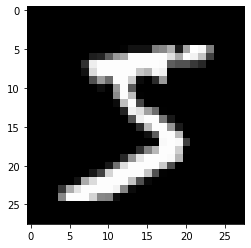

In [4]:
plt.imshow(X_train[0].reshape(28,28), cmap='gray')

### Normalizing the data

In [5]:
X_train = X_train/255
X_test = X_test/255

### One hot encoding our output vectors

- `5 - array([0,0,0,0,0,1,0,0,0,0])` - only one is active.

In [6]:
y_train.shape

(60000,)

In [7]:
from sklearn.preprocessing import LabelBinarizer

In [8]:
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

In [9]:
y_train.shape

(60000, 10)

In [10]:
X_train = X_train.T
y_train = y_train.T

### Slicing the data
- Here we choosen all of the data

In [11]:
num_data_to_process = 30000

In [12]:
X_train = X_train[:,:num_data_to_process]
y_train = y_train[:,:num_data_to_process]

In [13]:
print(X_train.shape)
print(y_train.shape)

(784, 30000)
(10, 30000)


_______
## Activation Functions

- `sigmoid`
- `relu`
- `softmax`

In [14]:
def sigmoid(Z):    
    A = 1/(1+np.exp(-Z))
    cache = Z    
    return A, cache

def relu(Z):   
    A = np.maximum(0,Z)    
    cache = Z 
    return A, cache

def softmax(Z):
    exps = np.exp(Z)
    cache=Z
    return exps / np.sum(exps),Z

## Gradients for Activation Functions

- Derivatives for activation functions.
- These are used in backpropogation.

In [15]:
def relu_backward(dA, cache):    
    Z = cache
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0    
    return dZ

def sigmoid_backward(dA, cache):    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)    
    return dZ

def softmax_backward(Z,cache):
    Z=cache
    length=10  
    num_data_to_process = 30000
    dZ=np.zeros((num_data_to_process,10))
    Z=np.transpose(Z)
    for row in range (0,num_data_to_process):
            den=(np.sum(np.exp(Z[row,:])))*(np.sum(np.exp(Z[row,:])))
            for col in range (0,10):
                sums=0
                for j in range (0,10):
                    if (j!=col):
                        sums=sums+(math.exp(Z[row,j]))
                
                dZ[row,col]=(math.exp(Z[row,col])*sums)/den           
    dZ=np.transpose(dZ)
    Z=np.transpose(Z)
    
    return dZ

________________________
 ## Initializing Parameters
 
We should not initialize weights with zero values because if we initialize all the units will try to learn the same thing.
 - Here we have two initializations
     - `random` 
     - `he` - works best for relu activation functions.

In [16]:
def initialize_parameters_deep(layer_dims):

    #np.random.seed(101)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.1
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1)) * 0.1
        
    return parameters

In [17]:
def initialize_parameters_he(layer_dims):
    
    np.random.seed(101)
    parameters = {}
    L = len(layer_dims) 
     
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2./layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

______
## Forward propagation

- Each hidden layer accepts the input data from the previous layer, processes it as per the linear and activation function and passes to the next layer.
- Each unit has two functions
    - `Linear function` 
    - `Activation function`
- Relu is used in the hidden layers and output layer uses softmax since we have categorical data.

###  Linear Forward 

The linear forward module computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$



In [18]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)    
    return Z, cache

## With Activation Function

In [19]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    elif activation == "softmax":
        Z,linear_cache=linear_forward(A_prev,W,b)
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

## For L Layers

In [20]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation="relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],activation="softmax")
    caches.append(cache)
            
    return AL, caches

_______
## Cost function

- The loss function for our neural network.
- Our goal is to minimize this cost.

In [21]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    return cost

______
## Backward Propogation
- It is the backward propogation of errors.
- It says how changing the weights and biases changes the cost function.

In [22]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [23]:
def linear_activation_backward(dA, cache, activation):\
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "softmax":
        dZ = softmax_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    
    return dA_prev, dW, db

In [24]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    M=len(layers_dims)
    current_cache = caches[M-2]
    
    grads["dA"+str(M-1)], grads["dW"+str(M-1)], grads["db"+str(M-1)] = linear_activation_backward(dAL, current_cache, activation = "softmax")#M-1
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

______
## Update Parameters


$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

- where $\alpha$ is the learning rate. 

In [25]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]
        
    return parameters

_____
## Predictions on the data

- It returns the predicted result and prints the accuracy for the given data.

In [26]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) 
    p = np.zeros(m)
    
    probas, cache = L_model_forward(X, parameters)

    for i in range(0, probas.shape[0]):
        p = np.argmax(probas,axis=0)

    result = np.mean(np.argmax(probas,axis=0) == np.argmax(y,axis=0))
    print("Accuracy: "  + str(result * 100))
      
    return p

-----
# L Layer Model

In [27]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 3000, print_cost=False,initialization='random'):

    np.random.seed(1)
    costs = []                         
    
    if initialization == "random":
        parameters = initialize_parameters_deep(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
                
        if print_cost: # and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs

## Training the model

In [33]:
layers_dims = [X_train.shape[0], 200, 100, 10]
print(layers_dims)

[784, 200, 100, 10]


Cost after iteration 0: 12.632650
Cost after iteration 1: 12.632512
Cost after iteration 2: 12.632376
Cost after iteration 3: 12.632240
Cost after iteration 4: 12.632105
Cost after iteration 5: 12.631972
Cost after iteration 6: 12.631840
Cost after iteration 7: 12.631708
Cost after iteration 8: 12.631577
Cost after iteration 9: 12.631448
Cost after iteration 10: 12.631319
Cost after iteration 11: 12.631192
Cost after iteration 12: 12.631066
Cost after iteration 13: 12.630941
Cost after iteration 14: 12.630817
Cost after iteration 15: 12.630694
Cost after iteration 16: 12.630572
Cost after iteration 17: 12.630451
Cost after iteration 18: 12.630331
Cost after iteration 19: 12.630212
Cost after iteration 20: 12.630095
Cost after iteration 21: 12.629978
Cost after iteration 22: 12.629862
Cost after iteration 23: 12.629747
Cost after iteration 24: 12.629633
Cost after iteration 25: 12.629520
Cost after iteration 26: 12.629408
Cost after iteration 27: 12.629296
Cost after iteration 28: 12.62

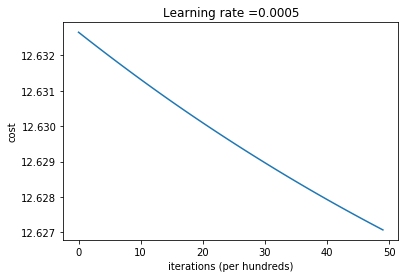

In [34]:
parameters, costs = L_layer_model(X_train, y_train, layers_dims,learning_rate=0.0005, num_iterations = 50, print_cost = True, initialization='he')

In [35]:
costs = np.array(costs)

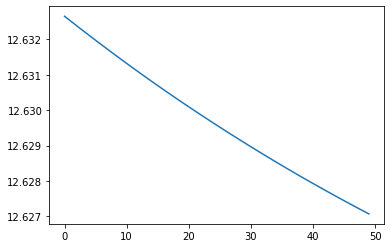

In [36]:
plt.plot(np.arange(len(costs)), costs)

## Predictions

In [ ]:
predictions_train = predict(X_train, y_train, parameters)

In [ ]:
predictions_test = predict(X_test.T, y_test.T, parameters)